In [2]:
from pandas import read_csv, Series
from gensim.models import Word2Vec
import numpy as np

In [3]:
from pymorphy2 import MorphAnalyzer
from nltk.tokenize import RegexpTokenizer
morph = MorphAnalyzer()
alpha_tokenizer = RegexpTokenizer('[A-Za-zА-Яа-я]\w+')

In [77]:
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, RandomForestRegressor
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.naive_bayes import BernoulliNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (accuracy_score, brier_score_loss, precision_score, recall_score, f1_score)
from sklearn.calibration import CalibratedClassifierCV, calibration_curve

In [5]:
df = read_csv('2ch_test_set.csv')
del df['index']

In [6]:
model = Word2Vec.load('2ch_model')
vocab = model.wv.vocab

In [7]:
def pre_process(sentence):
    sentence = sentence.lower()
    tokens = alpha_tokenizer.tokenize(sentence)
    model_tokens = []
    for index, word in enumerate(tokens):
        lem_word = morph.parse(word.lower())[0].normal_form
        if lem_word in vocab:
            model_tokens.append(lem_word)
    return model_tokens

In [8]:
old_err_state = np.seterr(all='raise')

def vectorize_message(sentence, model, num_features, vocab):
    featureVec = np.zeros((num_features), dtype='float32')
    nwords = 0
    
    tokens = pre_process(sentence.lower())

    for word in tokens:
        if word in vocab: 
            featureVec = np.add(featureVec, model[word])
            nwords = nwords + 1
    try:
        featureVec = np.divide(featureVec, nwords)
    except FloatingPointError:
         featureVec = np.zeros((num_features), dtype='float32')
    return featureVec

In [9]:
vec = []

for i in df.text.values:
    vec.append(vectorize_message(i, model, 400, vocab))

In [19]:
CHUNK = 40

X = np.array(vec)
Y = np.array(df.is_relevent.values)
X_train = X[:~CHUNK]
y_train = Y[:~CHUNK]
X_test = X[~CHUNK:]
y_test = Y[~CHUNK:]

In [11]:
X_test.shape

(41, 400)

In [11]:
clf = LogisticRegression(C = 1)
clf = clf.fit(X_train, Y_train)
result = clf.predict(X_test)
accuracy_score(Y_test, result)

0.75609756097560976

In [15]:
clf = RandomForestClassifier(n_estimators = 150)
clf = clf.fit(X_train, Y_train)
result = clf.predict(X_test)
accuracy_score(Y_test, result)

0.80487804878048785

In [29]:
clf = SVC(C = 0.01, kernel = 'linear')
clf = clf.fit(X_train, Y_train)
result = clf.predict(X_test)
accuracy_score(Y_test, result)

0.75609756097560976

In [16]:
clf.predict(np.array(vectorize_message('питон + генсим = годнота!', model, 400, vocab)).reshape(1,-1))

array([1])

In [19]:
clf.predict(np.array(vectorize_message('пошёл нахуй зелёный веб макакер', model, 400, vocab)).reshape(1,-1))

array([0])

Comparsion

Logistic Regression:
	Brier: 0.418
	Precision: 0.750
	Recall: 0.818
	F1: 0.783

Naive Bayes:
	Brier: 0.794
	Precision: 0.800
	Recall: 0.909
	F1: 0.851

Random Forest:
	Brier: 0.500
	Precision: 0.810
	Recall: 0.773
	F1: 0.791

Support Vector Machines:
	Brier: 0.284
	Precision: 0.714
	Recall: 0.909
	F1: 0.800

KNN:
	Brier: 0.610
	Precision: 0.808
	Recall: 0.955
	F1: 0.875



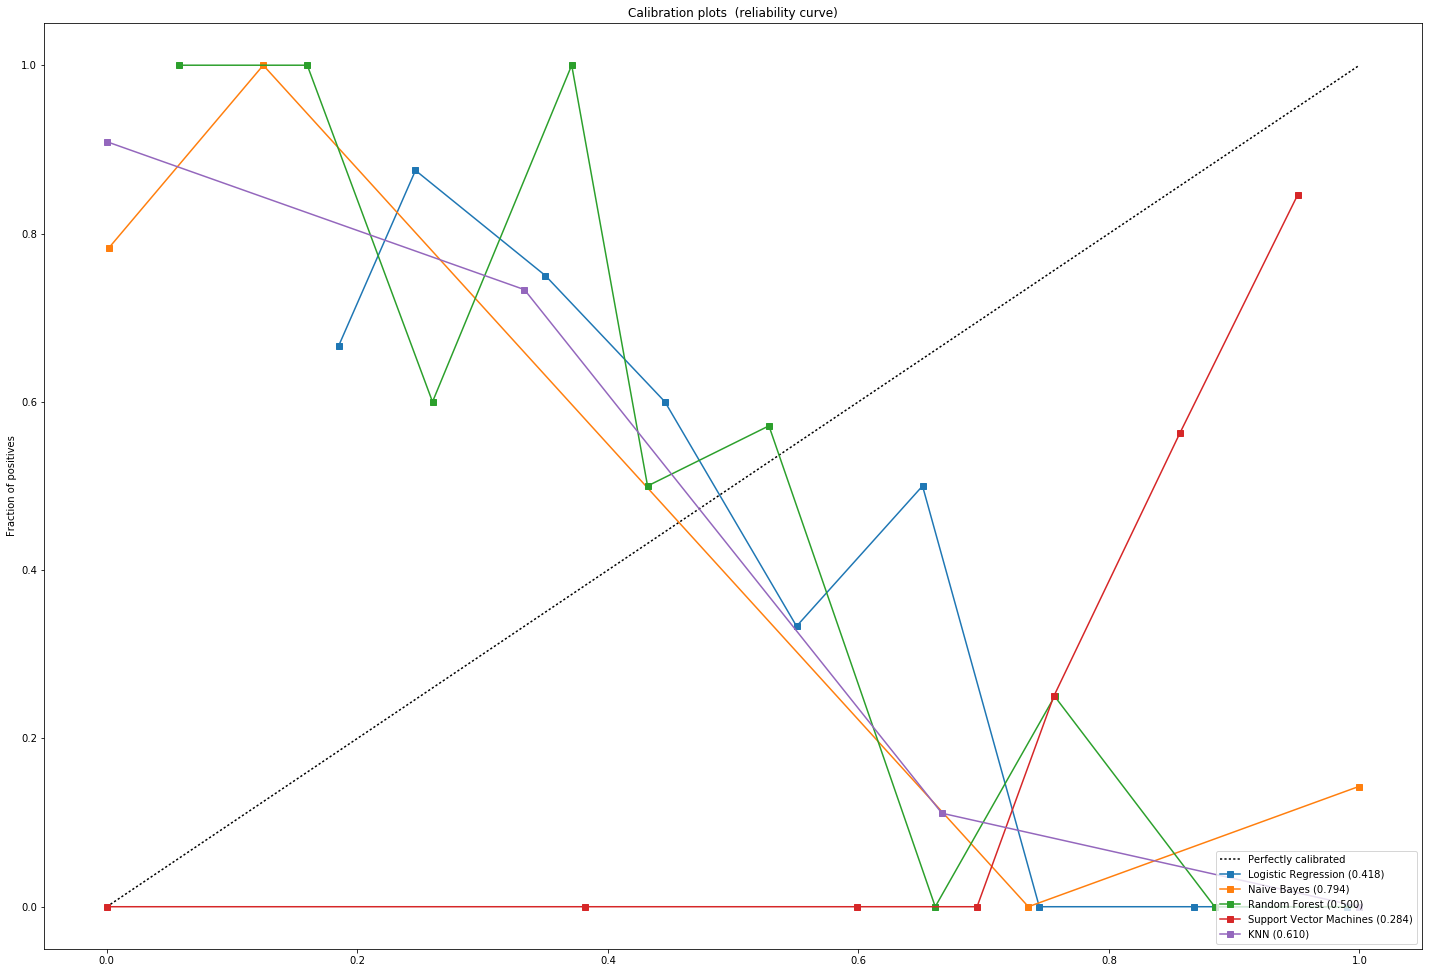

In [79]:
import matplotlib.pyplot as plt

est = LinearSVC()
name =  "SVC"
fig_index = 2
isotonic = CalibratedClassifierCV(est, cv=2, method='isotonic')
sigmoid = CalibratedClassifierCV(est, cv=2, method='sigmoid')
lr = LogisticRegression(C=1., solver='lbfgs')

fig = plt.figure(fig_index, figsize=(20, 20))
ax1 = plt.subplot2grid((3, 1), (0, 0), rowspan=2)

ax1.plot([0, 1], [0, 1], "k:", label="Perfectly calibrated")
for clf, name in [(LogisticRegression(C=0.05, solver='lbfgs'), 'Logistic Regression'),
                  (BernoulliNB(), 'Naive Bayes'),
                  (RandomForestClassifier(n_estimators = 150), 'Random Forest'),
                  (SVC(C = 0.01, kernel = 'linear'), 'Support Vector Machines'),
                  (KNeighborsClassifier(n_neighbors = 3), 'KNN')
                 ]:
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    if hasattr(clf, "predict_proba"):
        prob_pos = clf.predict_proba(X_test)[:, 0]
    else:  # use decision function
        prob_pos = clf.decision_function(X_test)
        prob_pos = (prob_pos - prob_pos.min()) / (prob_pos.max() - prob_pos.min())

    clf_score = brier_score_loss(y_test, prob_pos, pos_label=y.max())
    print("%s:" % name)
    print("\tBrier: %1.3f" % (clf_score))
    print("\tPrecision: %1.3f" % precision_score(y_test, y_pred))
    print("\tRecall: %1.3f" % recall_score(y_test, y_pred))
    print("\tF1: %1.3f\n" % f1_score(y_test, y_pred))

    fraction_of_positives, mean_predicted_value = \
        calibration_curve(y_test, prob_pos, n_bins=10)

    ax1.plot(mean_predicted_value, fraction_of_positives, "s-",
             label="%s (%1.3f)" % (name, clf_score))

ax1.set_ylabel("Fraction of positives")
ax1.set_ylim([-0.05, 1.05])
ax1.legend(loc="lower right")
ax1.set_title('Calibration plots  (reliability curve)')

plt.tight_layout()


plt.show()